In [1]:
import os
import subprocess
from itertools import product

# Define the range of parameters
queue_depths = [1,2,4,8]
num_queues = [1, 2, 4, 8]
block_sizes = [1, 2, 4, 8]
num_blocks = [1,2,4,8]
page_sizes = [4096]
io_types = [0, 1]
io_methods = [0, 1]
num_io = 10000

# Output directory for results
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

exec_path = os.path.join(os.getcwd(), "../build/bin/block-test")
print(f"Executable path: {exec_path}")

# Function to run the command and save results
def run_command_and_save_results(exec_path, params):
    queue_depth, num_queue, block_size, num_block, page_size, io_type, io_method = params
    output_file = os.path.join(
        output_dir, 
        f"qd{queue_depth}_nq{num_queue}_bs{block_size}_nb{num_block}_ps{page_size}_it{io_type}_im{io_method}.txt"
    )

    command = [
        "sudo", exec_path,
        f"--device", "0",
        f"--controller", "0",
        f"--queue-depth", str(queue_depth),
        f"--num-queues", str(num_queue),
        f"--block-size", str(block_size),
        f"--num-blocks", str(num_block),
        f"--page-size", str(page_size),
        f"--io-type", str(io_type),
        f"--io-method", str(io_method),
        f"--num-io", str(num_io)
    ]

    try:
        with open(output_file, "w") as f:
            result = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
            f.write(result.stdout)
            f.write("\\n--- STDERR ---\\n")
            f.write(result.stderr)
        print(f"Saved results to {output_file}")
    except Exception as e:
        print(f"Failed to run command: {e}")
        
# Generate all combinations of parameters
parameter_combinations = product(queue_depths, num_queues, block_sizes, num_blocks, page_sizes, io_types, io_methods)

# Run the commands for each combination
for params in parameter_combinations:
    run_command_and_save_results(exec_path, params)

print("All commands executed. Results are saved in the 'results' directory.")


Executable path: /export/home1/ltarun/bam-test/scripts/../build/bin/block-test
Saved results to results/qd1_nq1_bs1_nb1_ps4096_it0_im0.txt
Saved results to results/qd1_nq1_bs1_nb1_ps4096_it0_im1.txt
Saved results to results/qd1_nq1_bs1_nb1_ps4096_it1_im0.txt
Saved results to results/qd1_nq1_bs1_nb1_ps4096_it1_im1.txt
Saved results to results/qd1_nq1_bs1_nb2_ps4096_it0_im0.txt
Saved results to results/qd1_nq1_bs1_nb2_ps4096_it0_im1.txt
Saved results to results/qd1_nq1_bs1_nb2_ps4096_it1_im0.txt
Saved results to results/qd1_nq1_bs1_nb2_ps4096_it1_im1.txt
Saved results to results/qd1_nq1_bs1_nb4_ps4096_it0_im0.txt
Saved results to results/qd1_nq1_bs1_nb4_ps4096_it0_im1.txt
Saved results to results/qd1_nq1_bs1_nb4_ps4096_it1_im0.txt
Saved results to results/qd1_nq1_bs1_nb4_ps4096_it1_im1.txt
Saved results to results/qd1_nq1_bs1_nb8_ps4096_it0_im0.txt
Saved results to results/qd1_nq1_bs1_nb8_ps4096_it0_im1.txt
Saved results to results/qd1_nq1_bs1_nb8_ps4096_it1_im0.txt
Saved results to resu

{(1024, 1, 1, 1): [{'kernel_time': 15.200234375, 'data_transferred': 390.625, 'bandwidth': 25.698617, 'throughput': 6578.845927, 'page_size': 4096, 'io_type': 0, 'io_method': 1}], (1024, 1, 2, 1): [{'kernel_time': 18.599564453, 'data_transferred': 781.25, 'bandwidth': 42.003672, 'throughput': 10752.939968, 'page_size': 4096, 'io_type': 0, 'io_method': 1}], (1024, 1, 4, 1): [{'kernel_time': 21.233466797000002, 'data_transferred': 1562.5, 'bandwidth': 73.586665, 'throughput': 18838.186144, 'page_size': 4096, 'io_type': 0, 'io_method': 1}], (1024, 1, 16, 1): [{'kernel_time': 86.733507812, 'data_transferred': 6250.0, 'bandwidth': 72.059809, 'throughput': 18447.311084, 'page_size': 4096, 'io_type': 0, 'io_method': 1}], (1024, 1, 32, 1): [{'kernel_time': 167.429328125, 'data_transferred': 12500.0, 'bandwidth': 74.658366, 'throughput': 19112.541607, 'page_size': 4096, 'io_type': 0, 'io_method': 1}], (1024, 1, 64, 1): [{'kernel_time': 44.154527344, 'data_transferred': 25000.0, 'bandwidth': 566

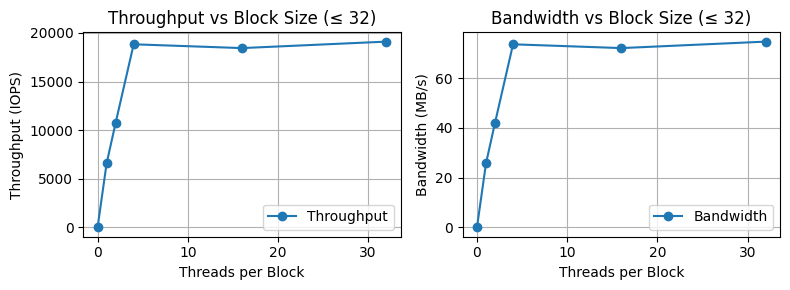

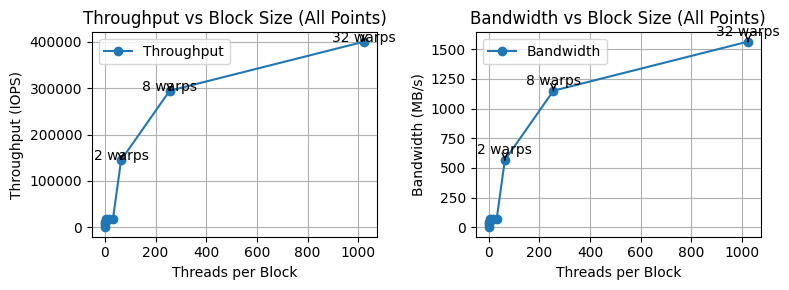

In [16]:
import os
import re
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

# Directory containing results
result_dir = "results"

plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

# # Define linestyles, markers, and colors
# linestyle_tuple = [
#     # ('loosely dotted', (0, (1, 10))),
#     ('dotted', (0, (1, 1))),
#     ('densely dotted', (0, (1, 1))),
#     ('long dash with offset', (5, (10, 3))),
#     ('loosely dashed', (0, (5, 10))),
#     ('dashed', (0, (5, 5))),
#     ('densely dashed', (0, (5, 1))),
#     ('loosely dashdotted', (0, (3, 10, 1, 10))),
#     ('dashdotted', (0, (3, 5, 1, 5))),
#     ('densely dashdotted', (0, (3, 1, 1, 1))),
#     ('dashdotdotted', (0, (3, 5, 1, 5, 1, 5))),
#     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
#     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
# ]

# marker_shapes = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'H', '+', 'x', 'X']
# colors = plt.cm.tab20.colors  # Use a colormap for distinct colors

# # Generate unique combinations of line style, marker, and color
# style_combinations = list(itertools.product(linestyle_tuple, marker_shapes, colors))

# Regular expressions to extract data
kernel_time_pattern = r"Kernel execution time:\s+([\d\.]+) ms"
data_transferred_pattern = r"Data transferred:\s+([\d\.]+) MB"
bandwidth_pattern = r"Bandwidth:\s+([\d\.]+) MB/s"
throughput_pattern = r"Throughput:\s+([\d\.]+) IOPS"

# Function to parse parameters from filenames
def parse_parameters(filename):
    params = {}
    for part in filename[:-4].split("_"):
        if part.startswith("qd"):
            params["queue_depth"] = int(part[2:])
        elif part.startswith("nq"):
            params["num_queues"] = int(part[2:])
        elif part.startswith("bs"):
            params["block_size"] = int(part[2:])
        elif part.startswith("nb"):
            params["num_blocks"] = int(part[2:])
        elif part.startswith("ps"):
            params["page_size"] = int(part[2:])
        elif part.startswith("it"):
            params["io_type"] = int(part[2:])
        elif part.startswith("im"):
            params["io_method"] = int(part[2:])
    return params

# Initialize results storage
results = defaultdict(list)

# Read all result files
for filename in os.listdir(result_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(result_dir, filename)
        with open(file_path, "r") as file:
            content = file.read()

            # Extract data using regex
            kernel_time_match = re.search(kernel_time_pattern, content)
            data_transferred_match = re.search(data_transferred_pattern, content)
            bandwidth_match = re.search(bandwidth_pattern, content)
            throughput_match = re.search(throughput_pattern, content)

            if kernel_time_match and data_transferred_match and bandwidth_match and throughput_match:
                params = parse_parameters(filename)
                results[(params["queue_depth"], params["num_queues"], params["block_size"], params["num_blocks"])].append({
                    "kernel_time": float(kernel_time_match.group(1)) / 1000,  # Convert to seconds
                    "data_transferred": float(data_transferred_match.group(1)),
                    "bandwidth": float(bandwidth_match.group(1)),
                    "throughput": float(throughput_match.group(1)),
                    "page_size": params.get("page_size"),
                    "io_type": params.get("io_type"),
                    "io_method": params.get("io_method")
                })

# Group and plot results
parameters = ["queue_depth", "num_queues", "block_size", "num_blocks"]
metrics = ["kernel_time", "bandwidth", "throughput", "data_transferred"]
ylabel_map = {
    "kernel_time": "Runtime (s)",
    "bandwidth": "Bandwidth (MB/s)",
    "throughput": "IOPS",
    "data_transferred": "Data Transferred (MB)"
}

# sort results by block size 
results = dict(sorted(results.items(), key=lambda x: x[0][2]))
print(results)

# get block sizes and their corresponding throughput and bandwidth
throughput_bandwidth = {}

for (queue_depth, num_queues, block_size, num_blocks), metrics_data_list in results.items():
    # print(f"Processing block size: {block_size}")
    throughput_bandwidth[block_size] = { "throughput": [], "bandwidth": [] }
    for metrics_data in metrics_data_list:
        throughput_bandwidth[block_size]["throughput"].append(metrics_data["throughput"])
        throughput_bandwidth[block_size]["bandwidth"].append(metrics_data["bandwidth"])
        

import matplotlib.pyplot as plt

# Extract block sizes and their throughput/bandwidth
block_sizes = list(throughput_bandwidth.keys())
throughputs = [sum(v["throughput"]) for v in throughput_bandwidth.values()]
bandwidths = [sum(v["bandwidth"]) for v in throughput_bandwidth.values()]

# Add the origin point (0, 0) for both throughput and bandwidth
block_sizes.insert(0, 0)
throughputs.insert(0, 0)
bandwidths.insert(0, 0)

# Separate block sizes for the first plot (<= 32)
small_block_sizes = [b for b in block_sizes if b <= 32]
small_throughputs = [throughputs[block_sizes.index(b)] for b in small_block_sizes]
small_bandwidths = [bandwidths[block_sizes.index(b)] for b in small_block_sizes]

# First Image: Points ≤ 32
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Throughput vs Block Size (≤ 32)
axes[0].plot(small_block_sizes, small_throughputs, label="Throughput", marker='o')
axes[0].set_title("Throughput vs Block Size (≤ 32)")
axes[0].set_xlabel("Threads per Block")
axes[0].set_ylabel("Throughput (IOPS)")
axes[0].grid()
axes[0].legend()

# Bandwidth vs Block Size (≤ 32)
axes[1].plot(small_block_sizes, small_bandwidths, label="Bandwidth", marker='o')
axes[1].set_title("Bandwidth vs Block Size (≤ 32)")
axes[1].set_xlabel("Threads per Block")
axes[1].set_ylabel("Bandwidth (MB/s)")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.savefig("plots/performance_small_block_sizes.svg", transparent=True)
plt.show()

# Second Image: All Points
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Throughput vs Block Size (All Points)
axes[0].plot(block_sizes, throughputs, label="Throughput", marker='o')
axes[0].set_title("Throughput vs Block Size (All Points)")
axes[0].set_xlabel("Threads per Block")
axes[0].set_ylabel("Throughput (IOPS)")
axes[0].grid()
axes[0].legend()

# Add warp annotations for throughput
warp_labels = {b: f"{int(b / 32)} warps" for b in block_sizes if b > 32}
for block_size, warp_label in warp_labels.items():
    throughput = throughputs[block_sizes.index(block_size)]
    axes[0].annotate(
        warp_label,
        xy=(block_size, throughput),
        xytext=(block_size, throughput + 50),  # Adjust offset as needed
        arrowprops=dict(facecolor='black', arrowstyle="->"),
        fontsize=10,
        ha='center'
    )

# Bandwidth vs Block Size (All Points)
axes[1].plot(block_sizes, bandwidths, label="Bandwidth", marker='o')
axes[1].set_title("Bandwidth vs Block Size (All Points)")
axes[1].set_xlabel("Threads per Block")
axes[1].set_ylabel("Bandwidth (MB/s)")
axes[1].grid()
axes[1].legend()

# Add warp annotations for bandwidth
for block_size, warp_label in warp_labels.items():
    bandwidth = bandwidths[block_sizes.index(block_size)]
    axes[1].annotate(
        warp_label,
        xy=(block_size, bandwidth),
        xytext=(block_size, bandwidth + 50),  # Adjust offset as needed
        arrowprops=dict(facecolor='black', arrowstyle="->"),
        fontsize=10,
        ha='center'
    )

plt.tight_layout()
plt.savefig("plots/performance_all_block_sizes.svg", transparent=True)
plt.show()



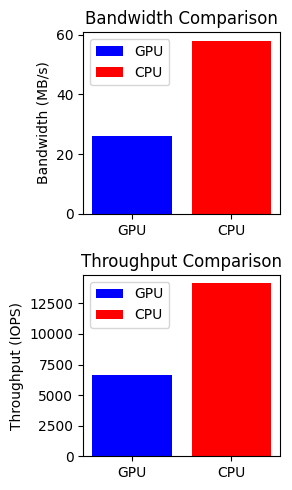

In [9]:
gpu_res = {
    "Bandwidth": 25.915588,
    "Throughput": 6634.390530
}
# Kernel execution time: 15072.974609 ms
# Data transferred:      390.625000 MB
# Bandwidth:             25.915588 MB/s
# Throughput:            6634.390530 IOPS

cpu_res = {
    "Bandwidth": 57.8784,
    "Throughput": 14130.5
}
# Throughput: 14130.5 IOPS
# Bandwidth: 57.8784 MB/s

from matplotlib import pyplot as plt

# Plot the results
fig, ax = plt.subplots(2, 1, figsize=(3, 5))

# Plot the bandwidth
ax[0].bar("GPU", gpu_res["Bandwidth"], color="blue", label="GPU")
ax[0].bar("CPU", cpu_res["Bandwidth"], color="red", label="CPU")
ax[0].set_ylabel("Bandwidth (MB/s)")
ax[0].set_title("Bandwidth Comparison")
ax[0].legend()

# Plot the throughput
ax[1].bar("GPU", gpu_res["Throughput"], color="blue", label="GPU")
ax[1].bar("CPU", cpu_res["Throughput"], color="red", label="CPU")
ax[1].set_ylabel("Throughput (IOPS)")
ax[1].set_title("Throughput Comparison")
ax[1].legend()

plt.tight_layout()
plt.savefig("plots/comparison.svg", transparent=True)
plt.show()

Num Blocks: 16384, Throughput: [926748.46421], Bandwidth: [3620.111188]
Num Blocks: 1024, Throughput: [631960.280309], Bandwidth: [2468.594845]
Num Blocks: 64, Throughput: [258589.715393], Bandwidth: [1010.116076]
Num Blocks: 256, Throughput: [532435.541632], Bandwidth: [2079.826335]
Num Blocks: 4, Throughput: [24293.835842], Bandwidth: [94.897796]
Num Blocks: 16, Throughput: [84726.795387], Bandwidth: [330.964044]
Num Blocks: 4096, Throughput: [862184.589937], Bandwidth: [3367.908554]
Num Blocks: 2, Throughput: [12788.402517], Bandwidth: [49.954697]
Num Blocks: 1, Throughput: [6579.233536], Bandwidth: [25.700131]
Bandwidth: [0, 25.700131, 49.954697, 94.897796, 330.964044, 1010.116076, 2079.826335, 2468.594845, 3367.908554, 3620.111188]
Block Sizes: [0, 1, 2, 4, 16, 64, 256, 1024, 4096, 16384]


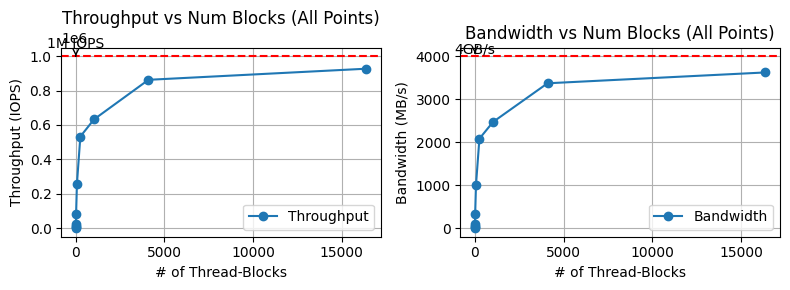

In [ ]:
import os
import re
import matplotlib.pyplot as plt
import itertools
from collections import defaultdict

# Directory containing results
result_dir = "results"

plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)

# # Define linestyles, markers, and colors
# linestyle_tuple = [
#     # ('loosely dotted', (0, (1, 10))),
#     ('dotted', (0, (1, 1))),
#     ('densely dotted', (0, (1, 1))),
#     ('long dash with offset', (5, (10, 3))),
#     ('loosely dashed', (0, (5, 10))),
#     ('dashed', (0, (5, 5))),
#     ('densely dashed', (0, (5, 1))),
#     ('loosely dashdotted', (0, (3, 10, 1, 10))),
#     ('dashdotted', (0, (3, 5, 1, 5))),
#     ('densely dashdotted', (0, (3, 1, 1, 1))),
#     ('dashdotdotted', (0, (3, 5, 1, 5, 1, 5))),
#     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
#     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))
# ]

# marker_shapes = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'H', '+', 'x', 'X']
# colors = plt.cm.tab20.colors  # Use a colormap for distinct colors

# # Generate unique combinations of line style, marker, and color
# style_combinations = list(itertools.product(linestyle_tuple, marker_shapes, colors))

# Regular expressions to extract data
kernel_time_pattern = r"Kernel execution time:\s+([\d\.]+) ms"
data_transferred_pattern = r"Data transferred:\s+([\d\.]+) MB"
bandwidth_pattern = r"Bandwidth:\s+([\d\.]+) MB/s"
throughput_pattern = r"Throughput:\s+([\d\.]+) IOPS"

# Function to parse parameters from filenames
def parse_parameters(filename):
    params = {}
    for part in filename[:-4].split("_"):
        if part.startswith("qd"):
            params["queue_depth"] = int(part[2:])
        elif part.startswith("nq"):
            params["num_queues"] = int(part[2:])
        elif part.startswith("bs"):
            params["block_size"] = int(part[2:])
        elif part.startswith("nb"):
            params["num_blocks"] = int(part[2:])
        elif part.startswith("ps"):
            params["page_size"] = int(part[2:])
        elif part.startswith("it"):
            params["io_type"] = int(part[2:])
        elif part.startswith("im"):
            params["io_method"] = int(part[2:])
    return params

# Initialize results storage
results = defaultdict(list)

# Read all result files
for filename in os.listdir(result_dir):
    if filename.endswith(".txt"):
        file_path = os.path.join(result_dir, filename)
        with open(file_path, "r") as file:
            content = file.read()

            # Extract data using regex
            kernel_time_match = re.search(kernel_time_pattern, content)
            data_transferred_match = re.search(data_transferred_pattern, content)
            bandwidth_match = re.search(bandwidth_pattern, content)
            throughput_match = re.search(throughput_pattern, content)

            if kernel_time_match and data_transferred_match and bandwidth_match and throughput_match:
                params = parse_parameters(filename)
                results[(params["queue_depth"], params["num_queues"], params["block_size"], params["num_blocks"])].append({
                    "kernel_time": float(kernel_time_match.group(1)) / 1000,  # Convert to seconds
                    "data_transferred": float(data_transferred_match.group(1)),
                    "bandwidth": float(bandwidth_match.group(1)),
                    "throughput": float(throughput_match.group(1)),
                    "page_size": params.get("page_size"),
                    "io_type": params.get("io_type"),
                    "io_method": params.get("io_method")
                })

# Group and plot results
parameters = ["queue_depth", "num_queues", "block_size", "num_blocks"]
metrics = ["kernel_time", "bandwidth", "throughput", "data_transferred"]
ylabel_map = {
    "kernel_time": "Runtime (s)",
    "bandwidth": "Bandwidth (MB/s)",
    "throughput": "IOPS",
    "data_transferred": "Data Transferred (MB)"
}

# sort results by block size 
results = dict(sorted(results.items(), key=lambda x: x[0][2]))

# get block sizes and their corresponding throughput and bandwidth
throughput_bandwidth = {}

for (queue_depth, num_queues, block_size, num_blocks), metrics_data_list in results.items():
    # get only where block size is 1 but num blokcs changes
    if block_size == 1:
        throughput_bandwidth[num_blocks] = { "throughput": [], "bandwidth": [] }
        for metrics_data in metrics_data_list:
            throughput_bandwidth[num_blocks]["throughput"].append(metrics_data["throughput"])
            throughput_bandwidth[num_blocks]["bandwidth"].append(metrics_data["bandwidth"])
            
for k,v in throughput_bandwidth.items():
    print(f"Num Blocks: {k}, Throughput: {v['throughput']}, Bandwidth: {v['bandwidth']}")
        
# sort by num blocks 
throughput_bandwidth = dict(sorted(throughput_bandwidth.items(), key=lambda x: int(x[0])))

import matplotlib.pyplot as plt

# Extract block sizes and their throughput/bandwidth
block_sizes = list(throughput_bandwidth.keys())
throughputs = [sum(v["throughput"]) for v in throughput_bandwidth.values()]
bandwidths = [sum(v["bandwidth"]) for v in throughput_bandwidth.values()]

# Add the origin point (0, 0) for both throughput and bandwidth
block_sizes.insert(0, 0)
throughputs.insert(0, 0)
bandwidths.insert(0, 0)

# Plot all points

fig, axes = plt.subplots(1, 2, figsize=(8, 3))

# Throughput vs Block Size (All Points)
axes[0].plot(block_sizes, throughputs, label="Throughput", marker='o')
axes[0].set_title("Throughput vs Num Blocks (All Points)")
axes[0].set_xlabel("# of Thread-Blocks")
axes[0].set_ylabel("Throughput (IOPS)")
axes[0].grid()
axes[0].legend()

# add horizontal line at 1m IOPS
axes[0].axhline(y=1000000, color='r', linestyle='--', label="1M IOPS")

# label the line
axes[0].annotate(
    "Max Throughput",
    xy=(block_sizes[1], 1000000),
    xytext=(block_sizes[1], 1000000 + 50000),  # Adjust offset as needed
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10,
    ha='center'
)

# Bandwidth vs Block Size (All Points)
print(f"Bandwidth: {bandwidths}")
print(f"Block Sizes: {block_sizes}")
axes[1].plot(block_sizes, bandwidths, label="Bandwidth", marker='o')
axes[1].set_title("Bandwidth vs Num Blocks (All Points)")
axes[1].set_xlabel("# of Thread-Blocks")
axes[1].set_ylabel("Bandwidth (MB/s)")
axes[1].grid()
axes[1].legend()

# add horizontal line at 4GB/s
axes[1].axhline(y=4000, color='r', linestyle='--', label="4GB/s")
# label the line
axes[1].annotate(
    "Max Bandwidth",
    xy=(block_sizes[1], 4000),
    xytext=(block_sizes[1], 4000 + 50),  # Adjust offset as needed
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    fontsize=10,
    ha='center'
)

plt.tight_layout()
plt.savefig("plots/performance_all_block.svg", transparent=True)
plt.show()

        